<a href="https://colab.research.google.com/github/Ash100/Minor/blob/main/Treating_JSON_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install Biopython

In [ ]:
!pip install Bio

### Extract PDB from the .JSON file

In [5]:
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PDBIO, Select
import json

class HeteroSelect(Select):
    def accept_atom(self, atom):
        return True  # include ATOM + HETATM

# Load JSON
with open("/content/boltz2-hco3.json", "r") as f:
    data = json.load(f)

mmcif_block = data["structures"][0]["structure"]

with open("temp.cif", "w") as f:
    f.write(mmcif_block)

parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("model", "temp.cif")

io = PDBIO()
io.set_structure(structure)
io.save("output.pdb", HeteroSelect())

print("✅ output.pdb saved with ligands and cofactors intact")


✅ output.pdb saved with ligands and cofactors intact


In [2]:
from Bio.PDB.MMCIFParser import MMCIFParser
from Bio.PDB import PDBIO
import json

# Load JSON
with open("/content/boltz2-doroboxcin.json", "r") as f:
    data = json.load(f)

# Extract mmCIF block
mmcif_block = data["structures"][0]["structure"]

# Save mmCIF text temporarily
with open("temp.cif", "w") as f:
    f.write(mmcif_block)

# Parse with Biopython
parser = MMCIFParser(QUIET=True)
structure = parser.get_structure("model", "temp.cif")

# Export to PDB
io = PDBIO()
io.set_structure(structure)
io.save("output.pdb")

print("✅ output.pdb saved with connectivity (PyMOL should display bonds correctly)")


✅ output.pdb saved with connectivity (PyMOL should display bonds correctly)


### Extract Metrices of your choice

In [ ]:
import json
import pandas as pd

# Provide your own ID here
run_id = "YP_009944270_3-587"   # <-- change this as needed

# Load JSON
with open("/content/YP_009944270_3-587.json", "r") as f:
    data = json.load(f)

# -------- Extract selected scores --------
selected_keys = [
    "confidence_scores",
    "ptm_scores",
    "iptm_scores",
    "complex_plddt_scores",
    "complex_pde_scores",
    "complex_ipde_scores"
]

selected_scores = {"ID": run_id}   # Start with ID
for key in selected_keys:
    if key in data:
        val = data[key]
        # Flatten single-element lists
        if isinstance(val, list) and len(val) == 1:
            val = val[0]
        selected_scores[key] = val

# Save as CSV
df_scores = pd.DataFrame([selected_scores])
df_scores.to_csv("YP_009944270_3-587.csv", index=False)

print("✅ selected_scores.csv saved with ID column")


✅ selected_scores.csv saved with ID column


Finding Missing data - comparing json and csv

In [ ]:
import os

# List all files in /content
files = os.listdir("/content")

# Separate JSON and CSV basenames (without extension)
json_files = {os.path.splitext(f)[0] for f in files if f.endswith(".json")}
csv_files  = {os.path.splitext(f)[0] for f in files if f.endswith(".csv")}

# Find JSON files with no matching CSV
missing_csv = json_files - csv_files

print("Total JSON:", len(json_files))
print("Total CSV :", len(csv_files))
print("\nJSON files with NO matching CSV:")
for name in sorted(missing_csv):
    print(name)


Total JSON: 45
Total CSV : 44

JSON files with NO matching CSV:
YP_009944270_3-587


In [ ]:
!rm -rf /content/*

Merge all the CSVs into one

In [ ]:
import pandas as pd
import glob
import os

# --- STEP 1: Point to the folder where you uploaded all CSV files ---
csv_folder = "/content"

# --- STEP 2: Collect all CSV files ---
all_files = glob.glob(os.path.join(csv_folder, "*.csv"))

print(f"Found {len(all_files)} CSV files.")

# --- STEP 3: Read and merge ---
dfs = []
for file in all_files:
    df = pd.read_csv(file)
    df["Source_File"] = os.path.basename(file)  # keep track of origin file
    dfs.append(df)

merged_df = pd.concat(dfs, ignore_index=True)

# --- STEP 4: Save merged file ---
output_file = "/content/merged_metrics.csv"
merged_df.to_csv(output_file, index=False)

print(f"✅ Merged CSV saved at: {output_file}")


Found 45 CSV files.
✅ Merged CSV saved at: /content/merged_metrics.csv


###Visualize the merged file for analysis

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load merged data
df = pd.read_csv("/content/merged_metrics.csv")

# Prepare metrics only
metrics_df = df.set_index("ID").drop(columns=["Source_File"], errors="ignore")

# --- Beautiful Heatmap ---
plt.figure(figsize=(14, 10))

sns.heatmap(metrics_df,
            cmap="mako",       # aesthetic colormap
            annot=True,        # show values
            fmt=".2f",
            linewidths=0.5,    # thin lines between cells
            linecolor="white",
            cbar_kws={'label': 'Metric Value'})

# Styling
plt.title("Boltz2 Metrics per ID", fontsize=16, weight="bold", pad=20)
plt.xticks(rotation=45, ha="right", fontsize=11, weight="bold")
plt.yticks(rotation=0, fontsize=9)

plt.tight_layout()
plt.show()


###Visualize the merged file with some clusterings

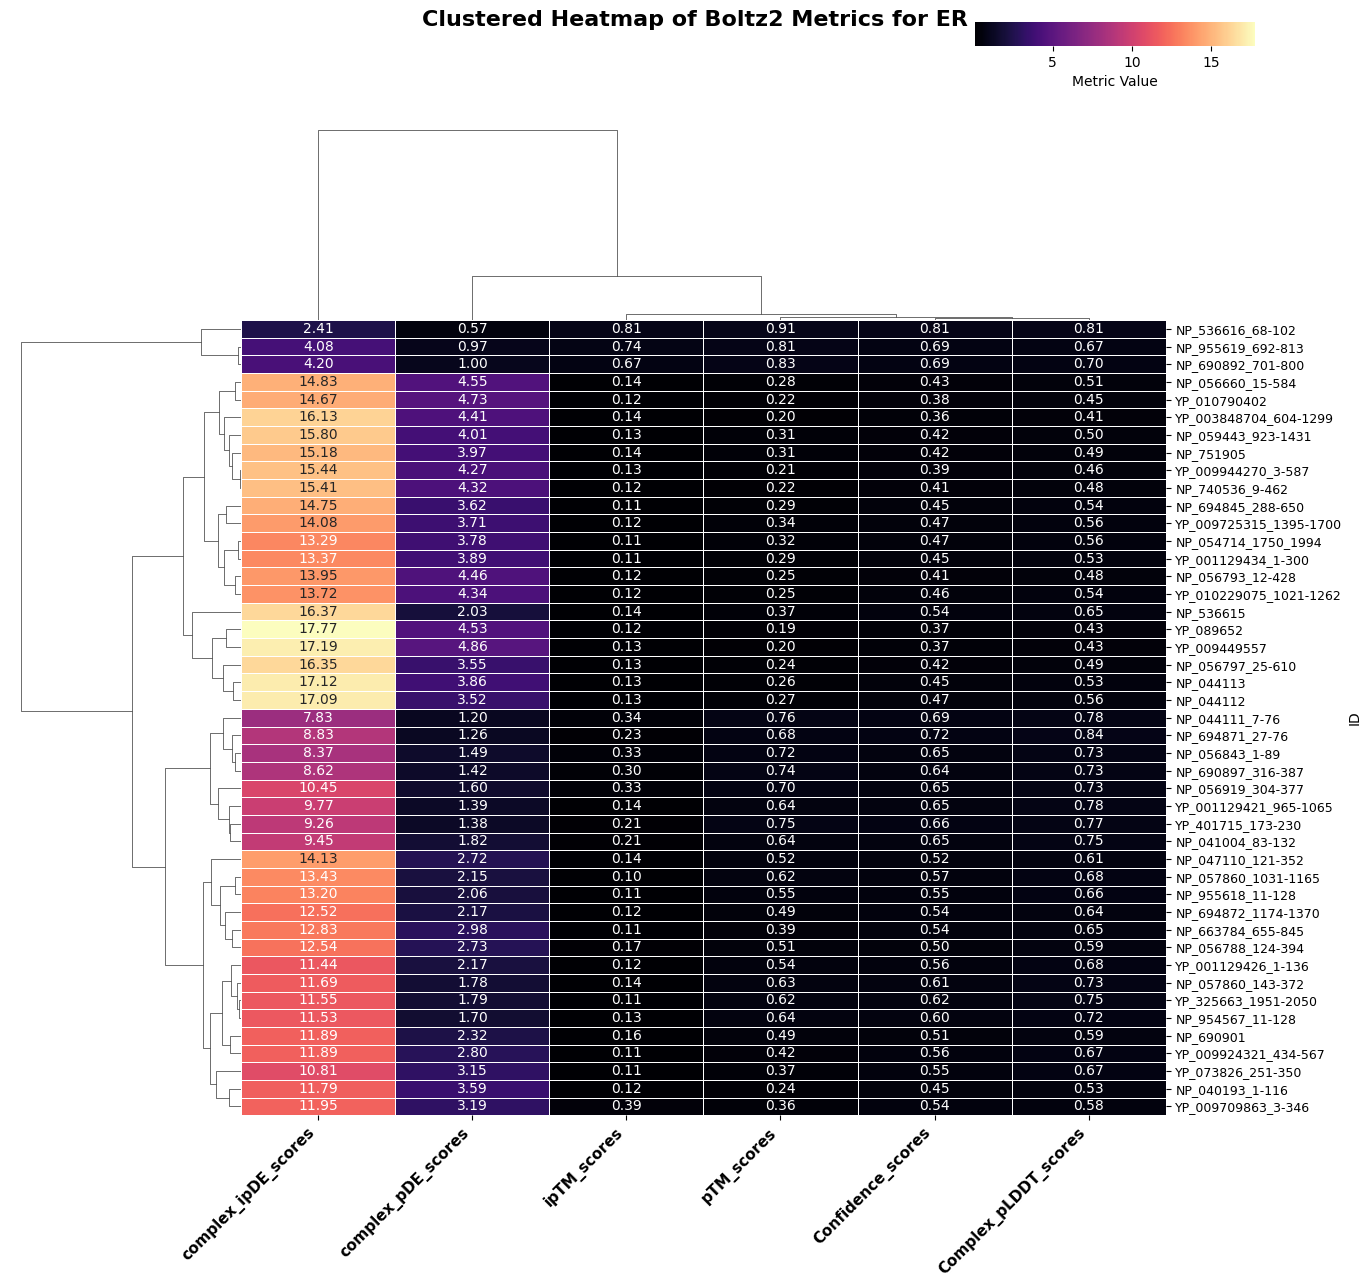

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clustered heatmap with colorbar repositioned
g = sns.clustermap(metrics_df,
                   cmap="magma",
                   annot=True,
                   fmt=".2f",
                   linewidths=0.5,
                   linecolor="white",
                   figsize=(14, 12),
                   cbar_pos=(0.7, 1.05, 0.2, 0.02),  # (x, y, width, height)
                   cbar_kws={'orientation': 'horizontal', 'label': 'Metric Value'})

# Format X-axis labels (metrics)
plt.setp(g.ax_heatmap.get_xticklabels(),
         rotation=45, ha="right", fontsize=11, fontweight="bold")

# Format Y-axis labels (IDs)
plt.setp(g.ax_heatmap.get_yticklabels(),
         rotation=0, fontsize=9)

# Add title
g.fig.suptitle("Clustered Heatmap of Boltz2 Metrics for ER",
               fontsize=16, weight="bold", y=1.08)

# --- Save figure at 800 dpi ---
g.fig.savefig("/content/boltz2_heatmap.png", dpi=800, bbox_inches="tight")

plt.show()
